<a href="https://colab.research.google.com/github/suminarwb/hate-speech-id/blob/main/LSTM_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
import os
import pandas as pd
from tqdm.auto import tqdm
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from gensim.models import FastText
import numpy as np # linear algebra

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Import everything that will be used
import string
import random
import logging
from keras.models import Sequential
from keras.layers import *
from keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Mounted at /content/drive


In [32]:
df = pd.read_csv("/content/drive/My Drive/Tesis/re_dataset.csv", encoding='Windows-1252')

df = df[['Tweet', 'HS']]
df.head()

,Tweet,HS
0,- disaat semua cowok berusaha melacak perhatia...,1
1,RT USER: USER siapa yang telat ngasih tau elu?...,0
2,"41. Kadang aku berfikir, kenapa aku tetap perc...",0
3,USER USER AKU ITU AKU\n\nKU TAU MATAMU SIPIT T...,0
4,USER USER Kaum cebong kapir udah keliatan dong...,1


In [33]:
df.shape

(13169, 2)

In [34]:
df.dropna(subset=['Tweet'])

,Tweet,HS
0,- disaat semua cowok berusaha melacak perhatia...,1
1,RT USER: USER siapa yang telat ngasih tau elu?...,0
2,"41. Kadang aku berfikir, kenapa aku tetap perc...",0
3,USER USER AKU ITU AKU\n\nKU TAU MATAMU SIPIT T...,0
4,USER USER Kaum cebong kapir udah keliatan dong...,1
...,...,...
13164,USER jangan asal ngomong ndasmu. congor lu yg ...,1
13165,USER Kasur mana enak kunyuk',0
13166,USER Hati hati bisu :( .g\n\nlagi bosan huft \...,0
13167,USER USER USER USER Bom yang real mudah terdet...,0


In [35]:
df.shape

(13169, 2)

In [36]:
# Create an iterator object that returns words properly formatted for Word2Vec training
class TweetsIterator:
    def __init__(self, dataset):
        self.dataset = dataset

        # The text contains a stupid special character, hence the + '–'
        self.translator = str.maketrans('', '', string.punctuation + '–')

    def __iter__(self):
        for review in self.dataset.iloc[:, 0]:
            # Make all characters lower-case
            #print(review)
            review =  review.lower()
            
            #[:-1] means 0 to n-1 column. cause last element after the last full stop is null. 
            for sentence in review.split('.')[:-1]:
                # Clean string of all punctuation
                #sentence = sentence.translate(self.translator)

                words = [w for w in sentence.split(' ') if w != '']

                yield words
                
sentences = TweetsIterator(df)

In [37]:
#w2v_model = FastText(sentences, size=100, window=5, min_count=10, workers=8)

#w2v_model.save('/content/drive/My Drive/Tesis/fasttext_trained_model')

In [38]:
fasttext_model = FastText.load('/content/drive/My Drive/Tesis/model.fasttext')
w2v_model = fasttext_model

In [39]:
ft_weights = fasttext_model.wv.vectors

In [40]:
vocab_size, embedding_size = ft_weights.shape
print("Vocabulary Size: {} - Embedding Dim: {}".format(vocab_size, embedding_size))

Vocabulary Size: 8076 - Embedding Dim: 100


In [41]:
import pickle

In [42]:
#with open("/content/drive/My Drive/Tesis/fasttext_final_vector.pickle", "wb") as fp:   #Pickling
#   pickle.dump(ft_weights, fp)

In [43]:
#with open("/content/drive/My Drive/Tesis/fasttext_final_vector.pickle", "rb") as fp:   # Unpickling
#    ft_weights = pickle.load(fp)

In [44]:
fasttext_model_wv = fasttext_model.wv

In [45]:
fasttext_model_wv.most_similar('presiden')

[('president', 0.7462741136550903),
 ('presiden..', 0.6589812636375427),
 ('presidenku', 0.6529889702796936),
 ('pres', 0.603832483291626),
 ('presidennya', 0.5811523199081421),
 ('lengserkan', 0.5420330166816711),
 ('jokowi', 0.5365720987319946),
 ('wapres', 0.5363028049468994),
 ('prabowoforpresiden2019', 0.5181159973144531),
 ('2019gantipresiden', 0.515064001083374)]

In [46]:
#function
def word2token(word):
    try:
        return w2v_model.wv.vocab[word].index
    # If word is not in index return 0. I realize this means that this
    # is the same as the word of index 0 (i.e. most frequent word), but 0s
    # will be padded later anyway by the embedding layer (which also
    # seems dirty but I couldn't find a better solution right now)
    except KeyError:
        return 0
def token2word(token):
    return w2v_model.wv.index2word[token]

In [47]:
from sklearn.manifold import TSNE

In [48]:
vocab_size, embedding_layer_input_size = ft_weights.shape
print(vocab_size, embedding_layer_input_size)

8076 100


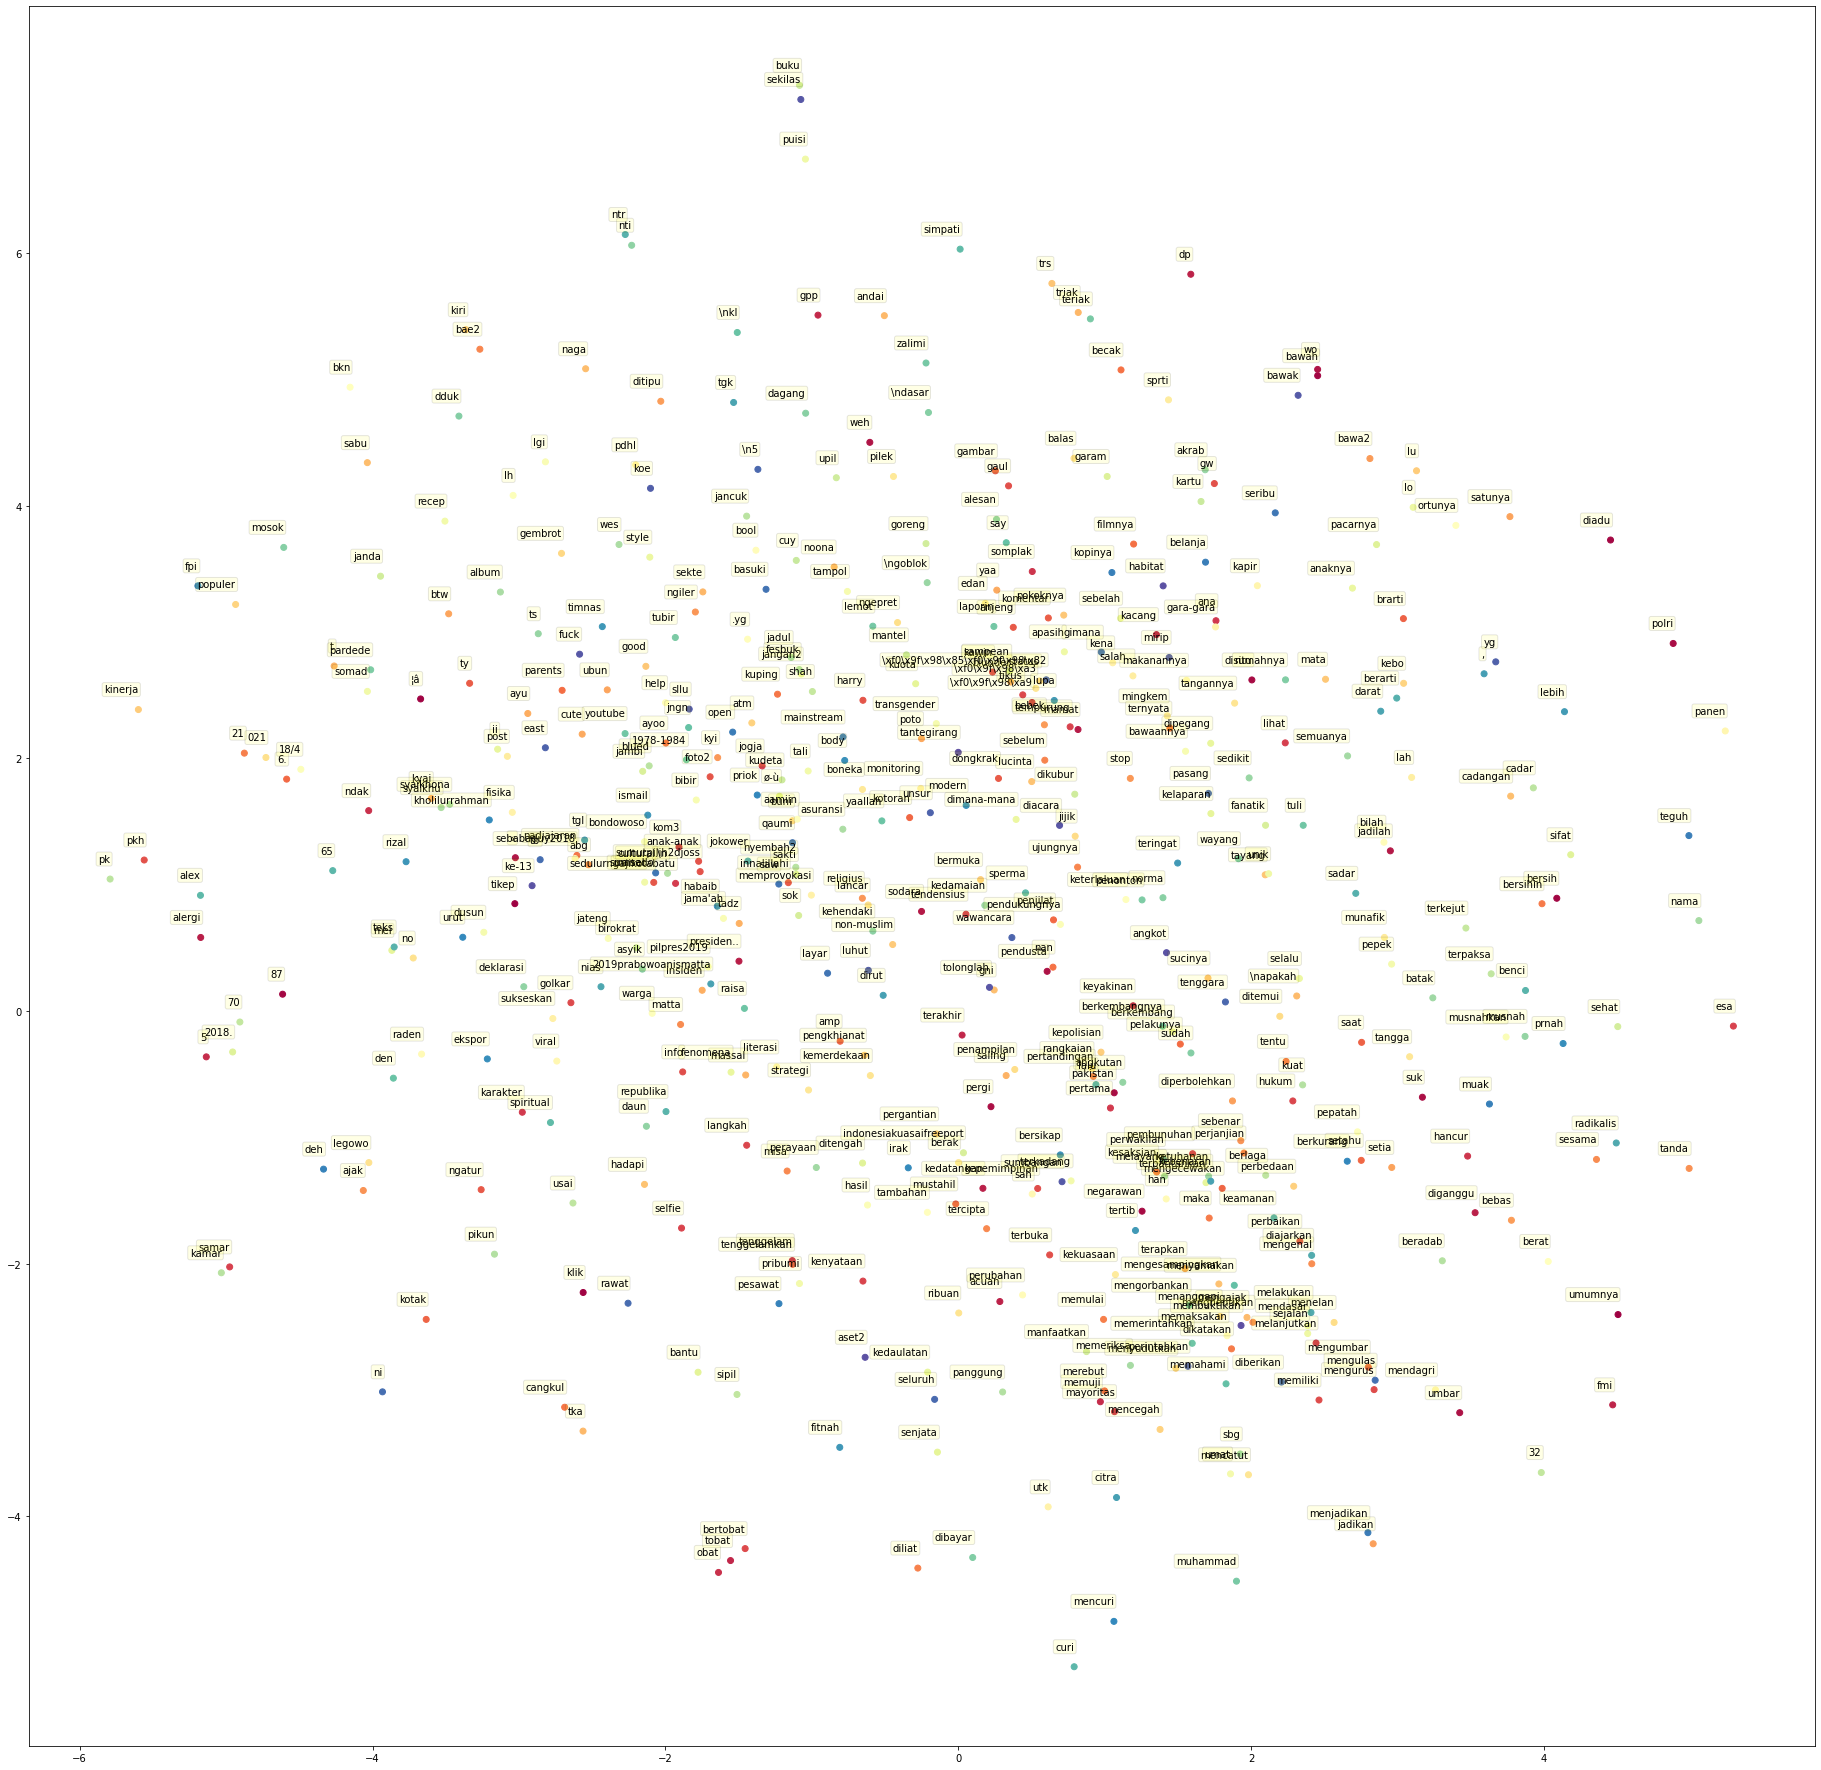

In [49]:
n_samples = 500
# Sample random words from model dictionary
random_i = random.sample(range(vocab_size), n_samples)
random_w = [token2word(i) for i in random_i]

# Generate fasttext embeddings of each word
word_vecs = np.array([fasttext_model_wv[w] for w in random_w])

# Apply t-SNE to Word2Vec embeddings, reducing to 2 dims
tsne = TSNE()
tsne_e = tsne.fit_transform(word_vecs)

# Plot t-SNE result
plt.figure(figsize=(32, 32))
plt.scatter(tsne_e[:, 0], tsne_e[:, 1], marker='o', c=range(len(random_w)), cmap=plt.get_cmap('Spectral'))

for label, x, y, in zip(random_w, tsne_e[:, 0], tsne_e[:, 1]):
    plt.annotate(label,
                 xy=(x, y), xytext=(0, 15),
                 textcoords='offset points', ha='right', va='bottom',
                 bbox=dict(boxstyle='round, pad=0.2', fc='yellow', alpha=0.1))

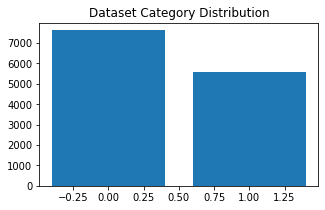

In [50]:
categories, ccount = np.unique(df.HS, return_counts=True)

plt.figure(figsize=(5, 3))
plt.title("Dataset Category Distribution")
plt.bar(categories, ccount, align='center')
plt.show()

In [51]:
df.shape

(13169, 2)

In [52]:
def word2idx(word):
    try:
        return fasttext_model_wv.vocab[word].index
    # If word is not in index return 0. I realize this means that this
    # is the same as the word of index 0 (i.e. most frequent word), but 0s
    # will be padded later anyway by the embedding layer (which also
    # seems dirty but I couldn't find a better solution right now)
    except KeyError:
        return 0
    
def idx2word(idx):
    return fasttext_model_wv.index2word[idx]

In [53]:

# Create an iterator that formats data from the dataset proper for
# LSTM training

# Sequences will be padded or truncated to this length
MAX_SEQUENCE_LENGTH = 200

# Samples of categories with less than this number of samples will be ignored

class SequenceIterator:
    def __init__(self, dataset, seq_length):
        self.dataset = dataset

        self.translator = str.maketrans('', '', string.punctuation + '–')
        self.HS, self.ccount = np.unique(dataset.HS, return_counts=True)
        
        self.seq_length = seq_length
        
    def __iter__(self):
        for review, score in zip(self.dataset.iloc[:, 0], self.dataset.iloc[:, 1]):
            # Make all characters lower-case
            review = review.lower()
            
            # Clean string of all punctuation
            #review = review.translate(self.translator)

            words = np.array([word2idx(w) for w in review.split(' ')[:self.seq_length] if w != ''])
                                
            # basically what is being done here is this - we take the review and score of a row. 
            # then we send the score intact
            # but, we take the review and split it into an array of words. then those words are searched in the fasttext_model_wv
            # and their index in that model's internal map / dictionary is found. those indexes are saved in an array. 
            # this array is padded with 0 so that these can be of MAX_LENGTH
            # replacing not found elements with 0 doesn't harm as it's the most used word, it will be ignored at some point. 
            
            yield (words, score)

sequences = SequenceIterator(df, MAX_SEQUENCE_LENGTH)

In [54]:
# Used for generating the labels in the set
# cat_dict = {k: v for k, v in zip(sequences.categories, range(len(sequences.categories)))}

# we don't need this dictionary actually as our score field itself contains integer values. 
# although if you want you can name them. 

score_dict = {
                0 : 'Netral', 
                1 : 'Hate Speech'
             }

             

set_x = []
set_y = []

for w, s in sequences:
    set_x.append(w)
#     set_y.append(cat_dict[c])
    set_y.append(s)
    
    
# Padding sequences with 0.
set_x = pad_sequences(set_x, maxlen=MAX_SEQUENCE_LENGTH, padding='pre', value=0)
set_y = np.array(set_y)

In [55]:
set_y

array([1, 0, 0, ..., 0, 0, 1])

In [56]:
print(set_x.shape)

# set_y just has the score values serially. 

print(set_y.shape)

(13169, 200)
(13169,)


Train Shapes - X: (10535, 200) - Y: (10535,)
Val Shapes - X: (2634, 200) - Y: (2634,)


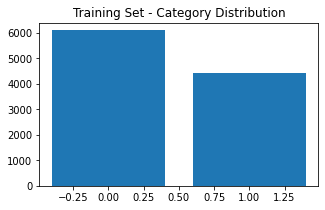

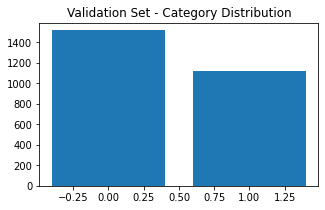

In [71]:
VALID_PER = 0.20 # Percentage of the whole set that will be separated for validation

from sklearn.model_selection import train_test_split
total_samples = set_x.shape[0]
n_val = int(VALID_PER * total_samples)
n_train = total_samples - n_val

#random_i = random.sample(range(total_samples), total_samples)
#train_x = set_x[random_i[:n_train]]
#train_y = set_y[random_i[:n_train]]
#val_x = set_x[random_i[n_train:n_train+n_val]]
#val_y = set_y[random_i[n_train:n_train+n_val]]

train_x, val_x, train_y, val_y = train_test_split(set_x, set_y, test_size=VALID_PER, random_state=42)

print("Train Shapes - X: {} - Y: {}".format(train_x.shape, train_y.shape))
print("Val Shapes - X: {} - Y: {}".format(val_x.shape, val_y.shape))

# Let's look at the distribution of categories in both sets
categories, ccount = np.unique(train_y, return_counts=True)
plt.figure(figsize=(5,3))
plt.title("Training Set - Category Distribution")
# plt.xticks(range(len(score_dict)), score_dict.values())
plt.bar(categories, ccount, align='center')
plt.show()

categories, ccount = np.unique(val_y, return_counts=True)
plt.figure(figsize=(5,3))
plt.title("Validation Set - Category Distribution")
# plt.xticks(range(len(categories)), cat_dict.keys())
plt.bar(categories, ccount, align='center')
plt.show()

n_categories = len(categories)


In [72]:
vocab_size, embedding_layer_output_size = ft_weights.shape
print(vocab_size, embedding_layer_output_size)

8076 100


In [88]:
#for i in range(len(train_y)): 
#   train_y[i] = train_y[i] - 1
#
#for i in range(len(val_y)): 
#   val_y[i] = val_y[i] - 1
    

    
model = Sequential()

# Keras Embedding layer with Word2Vec weights initialization
model.add(Embedding(input_dim=vocab_size, # 34867
                    output_dim=embedding_layer_output_size, # 100
                    weights=[ft_weights],
                    input_length=MAX_SEQUENCE_LENGTH, # 200
                    mask_zero=True,
                    trainable=False))

#model.add(Bidirectional(LSTM(100)))
model.add(SpatialDropout1D(0.1))
model.add(LSTM(20, dropout=0.1, recurrent_dropout=0.1))
model.add(Dense(n_categories, activation='sigmoid'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(train_x, train_y, epochs=10, batch_size=64,
                    validation_data=(val_x, val_y), verbose=1, shuffle=False)

Epoch 1/10
165/165 [==============================] - 46s 254ms/step - loss: 0.6685 - accuracy: 0.5940 - val_loss: 0.5508 - val_accuracy: 0.7198
Epoch 2/10
165/165 [==============================] - 41s 251ms/step - loss: 0.5395 - accuracy: 0.7298 - val_loss: 0.4850 - val_accuracy: 0.7722
Epoch 3/10
165/165 [==============================] - 41s 247ms/step - loss: 0.4780 - accuracy: 0.7718 - val_loss: 0.4632 - val_accuracy: 0.7844
Epoch 4/10
165/165 [==============================] - 41s 248ms/step - loss: 0.4470 - accuracy: 0.7896 - val_loss: 0.4587 - val_accuracy: 0.7870
Epoch 5/10
165/165 [==============================] - 41s 247ms/step - loss: 0.4306 - accuracy: 0.8001 - val_loss: 0.4579 - val_accuracy: 0.7931
Epoch 6/10
165/165 [==============================] - 41s 251ms/step - loss: 0.4097 - accuracy: 0.8084 - val_loss: 0.4541 - val_accuracy: 0.7976
Epoch 7/10
165/165 [==============================] - 42s 253ms/step - loss: 0.4021 - accuracy: 0.8129 - val_loss: 0.4535 - val_ac

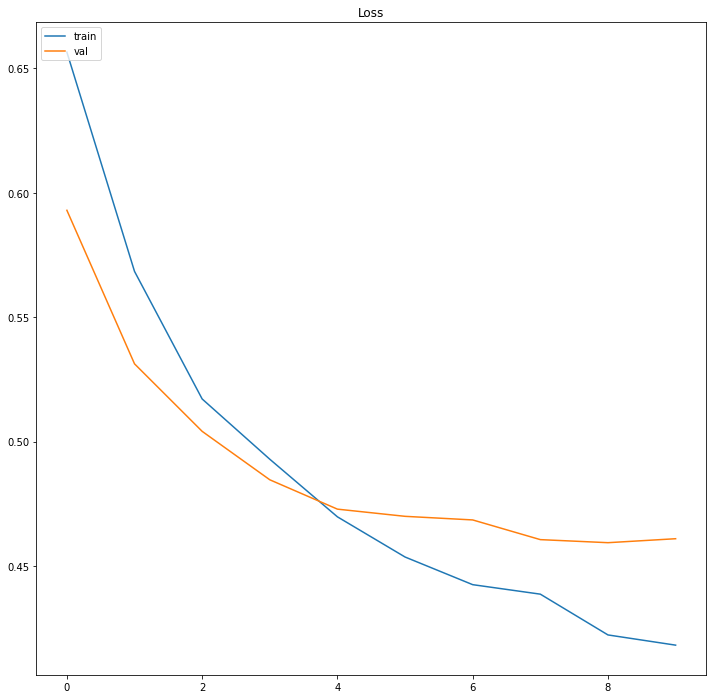

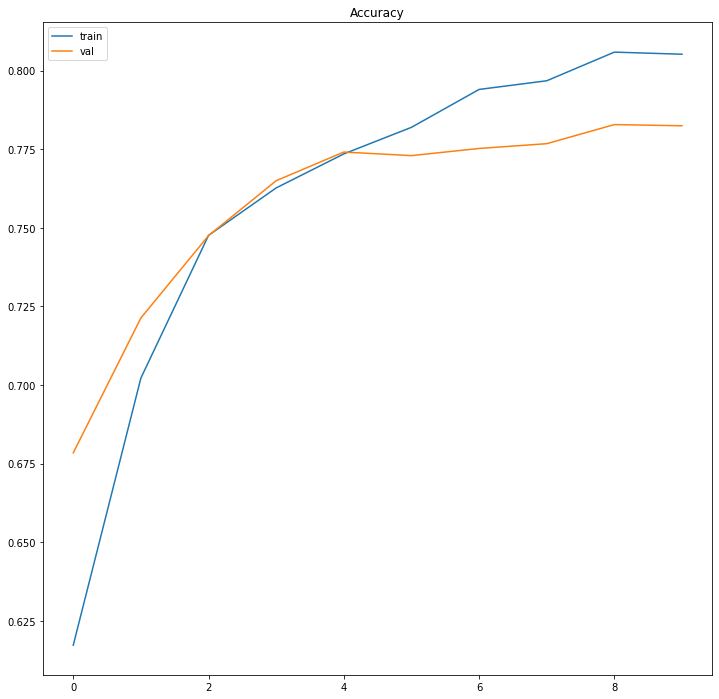

In [84]:
# Plotting Loss and Accuracy Graphs
plt.figure(figsize=(12, 12))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(12, 12))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [89]:
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score, confusion_matrix

y_pred = model.predict(val_x, verbose=1, batch_size=64)
y_pred_bool = np.argmax(y_pred, axis=1)

print(classification_report(y_pred_bool, val_y))
print('Precision Score : ', precision_score(val_y, y_pred_bool , average="macro"))
print('Recall Score : ', recall_score(val_y, y_pred_bool , average="macro"))
print('F1 Score : ', f1_score(val_y, y_pred_bool , average="macro"))

print(confusion_matrix(y_pred_bool, val_y))

print(y_pred.shape)

42/42 [==============================] - 2s 36ms/step
              precision    recall  f1-score   support

           0       0.83      0.82      0.83      1523
           1       0.76      0.77      0.76      1111

    accuracy                           0.80      2634
   macro avg       0.79      0.80      0.80      2634
weighted avg       0.80      0.80      0.80      2634

Precision Score :  0.795332356610579
Recall Score :  0.7948383610008449
F1 Score :  0.7950794007202022
[[1256  267]
 [ 260  851]]
(2634, 2)


In [90]:
accr = model.evaluate(val_x, val_y)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

83/83 [==============================] - 2s 28ms/step - loss: 0.4576 - accuracy: 0.7999
Test set
  Loss: 0.458
  Accuracy: 0.800


In [77]:
model.save("/content/drive/My Drive/Tesis/model_lstm_val2")

INFO:tensorflow:Assets written to: /content/drive/My Drive/Tesis/model_lstm_val2/assets


In [78]:



#pred = model.predict(padded)
#
#labels = ['0', '1']
#print(pred, labels[np.argmax(pred)])